In [43]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import scanpy as sc

from figurefirst import FigureLayout,mpl_functions
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In the previous script we used a random forest classifier for response modeling and achieved 65% accuracy, here we will use a CNN mainly to see if we can have a better response model.

In [44]:
df = pd.read_hdf('../merged.h5')
df.rename(columns={'orig.ident': 'cartid'}, inplace=True)
response_mapping = {
    'notresponding': 0,
    'partialresponse': 1,
    'completeresponse': 2
}
df['encoded_response'] = df['response'].map(response_mapping)
df = df[df['percent.mt'] < 8]  # Less than 5% mitochondrial genes -> because more mitcondrial content shows stressed or dieing cell - chose 8 to avoid skewness in the data
df.reset_index(inplace=True, drop=True)
## Normalization
df.iloc[:, 1:-12]=df.iloc[:, 1:-12].div(df['nCount_RNA'], axis=0) * 1e4

df_convert = df.iloc[:, 1:-12].astype(float)
remaining_columns = pd.concat([df.iloc[:, :1], df.iloc[:, -12:]], axis=1)

# Concatenate the unconverted columns with df_converted
final_df = pd.concat([remaining_columns, df_convert], axis=1)
final_df.iloc[:, 13:] =final_df.iloc[:, 13:].apply(np.log1p)

adata = sc.AnnData(final_df.iloc[:, 13:])  # Gene columns are in these indices
metadata_columns = final_df.iloc[:, :13] 
## visualizing highly variable genes

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
highly_variable_genes = adata.var[adata.var['highly_variable']].index
final_df = final_df.loc[:, final_df.columns.isin(highly_variable_genes)]
new_df = pd.concat([metadata_columns, final_df], axis=1)

In [10]:
# import h5py
# with h5py.File("../cell_embeddings.h5", "w") as hf:
#     hf.create_dataset("embeddings", data=final_embeddings)
# np.save("../cell_embeddings.npy", final_embeddings)
# print("Embeddings saved as 'cell_embeddings.npy'.")

# print("Embeddings saved as 'cell_embeddings.h5'.")

In [45]:
scaler = StandardScaler()
X = new_df.iloc[:, 13:]  # Gene expression data
y = new_df['encoded_response']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

X_train_t = torch.tensor(X_train_np).float()
y_train_t = torch.tensor(y_train_np).long()
X_test_t = torch.tensor(X_test_np).float()
y_test_t = torch.tensor(y_test_np).long()

# Create Tensor Datasets and DataLoaders for batch processing
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [46]:
# class SimpleNN(nn.Module):
#     def __init__(self):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(X_train_np.shape[1], 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 32)
#         self.fc4 = nn.Linear(32, len(np.unique(y_train)))  # Assuming classification task

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, 0.5)
#         x = F.relu(self.fc2(x))
#         x = F.dropout(x, 0.5)
#         x = F.relu(self.fc3(x))
#         x = F.dropout(x, 0.5)
#         x = self.fc4(x)
#         return x

In [47]:
class SimpleCNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)  # 32 output channels, kernel size of 5
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # Correct calculation of the flattened size before the fully connected layer
        self.num_flat_features = 64 * (num_features // 4)  # Update this calculation based on actual output size
        self.fc1 = nn.Linear(self.num_flat_features, 128)  # Use the updated flattened size
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [48]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50, loss_threshold=0.05):
    model.train()
    for epoch in range(num_epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Early stopping condition based on the loss threshold
            if loss.item() < loss_threshold:
                print(f'Stopping training at Epoch {epoch+1}, Batch Loss: {loss.item()}')
                return  # Exit the training function early
        scheduler.step()  
        print(f'Epoch {epoch+1}, Last Batch Loss: {loss.item()}')

num_features = X_train.shape[1]  # number of features, based on your preprocessed input
num_classes = len(np.unique(y_train))  # number of unique classes


model = SimpleCNN(num_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50, loss_threshold=0.01)



Epoch 1, Last Batch Loss: 0.8483155965805054
Epoch 2, Last Batch Loss: 0.4716948866844177
Epoch 3, Last Batch Loss: 0.5086243152618408
Epoch 4, Last Batch Loss: 0.8939453959465027
Epoch 5, Last Batch Loss: 0.345220685005188
Epoch 6, Last Batch Loss: 0.49747130274772644
Epoch 7, Last Batch Loss: 0.4519181549549103
Epoch 8, Last Batch Loss: 0.6593925952911377
Epoch 9, Last Batch Loss: 0.3313993811607361
Epoch 10, Last Batch Loss: 0.1642005294561386
Epoch 11, Last Batch Loss: 0.6637731194496155
Epoch 12, Last Batch Loss: 0.1540522575378418
Epoch 13, Last Batch Loss: 0.2220696359872818
Epoch 14, Last Batch Loss: 0.07366368174552917
Epoch 15, Last Batch Loss: 0.05103573948144913
Epoch 16, Last Batch Loss: 0.2568487823009491
Epoch 17, Last Batch Loss: 0.01398537214845419
Epoch 18, Last Batch Loss: 0.4007618725299835
Epoch 19, Last Batch Loss: 0.10796801745891571
Epoch 20, Last Batch Loss: 0.17165540158748627
Epoch 21, Last Batch Loss: 0.2033226191997528
Epoch 22, Last Batch Loss: 0.031808484

In [49]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

evaluate_model(model, test_loader)


Accuracy: 76.68175937904269%


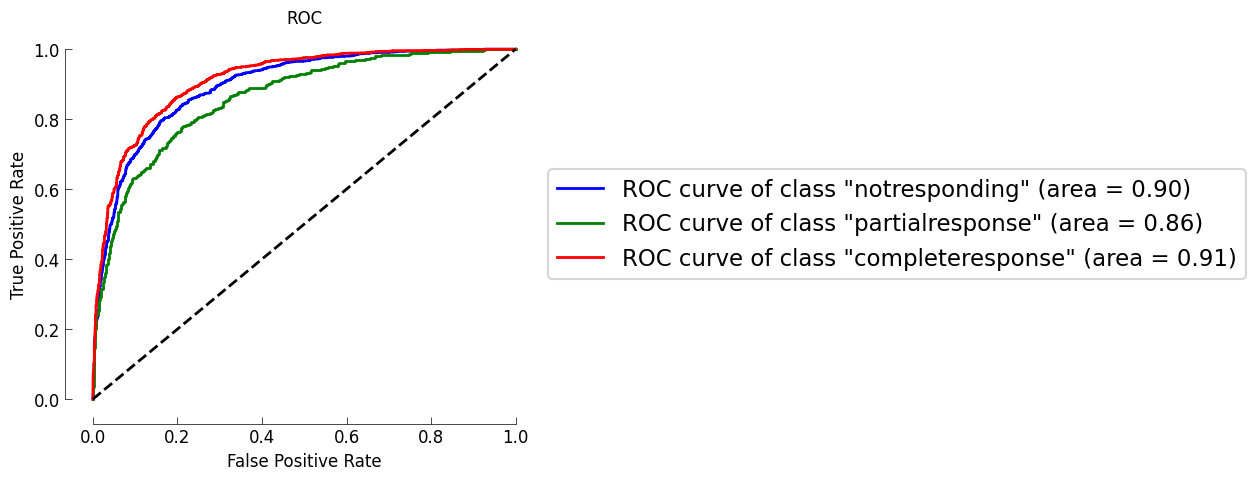

In [50]:
def plot_multiclass_roc(model, test_loader, num_classes, class_names):
    y_scores, y_true = [], []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)
            y_scores.append(probabilities.cpu().numpy())
            y_true.append(target.cpu().numpy())

    # Convert lists to numpy arrays for further processing
    y_scores = np.vstack(y_scores)
    y_true = np.concatenate(y_true)

    # Binarize the labels for all classes
    y_true = label_binarize(y_true, classes=range(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    f, ax = plt.subplots(1, 1, figsize=(6, 5))
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
    for i, color in zip(range(num_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class "{0}" (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                spine_locations={'left': 5, 'bottom': 5},
                                smart_bounds=True, 
                                xticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                linewidth=0.5)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    mpl_functions.set_fontsize(f, 12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

num_classes = 3
class_names = ["notresponding", "partialresponse", "completeresponse"]
plot_multiclass_roc(model, test_loader, num_classes, class_names)


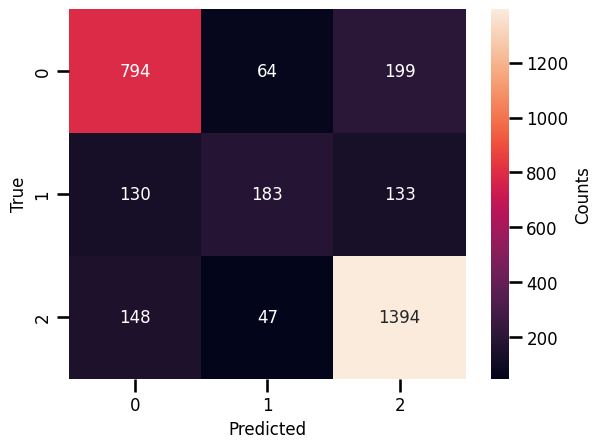

In [51]:

def evaluate_model(model, test_loader):
    y_pred, y_true = [], []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, preds = torch.max(output, 1)
            y_pred.extend(preds.tolist())
            y_true.extend(target.tolist())
    cm = confusion_matrix(y_true, y_pred)
    f,ax=plt.subplots(1,1)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax,  cbar_kws={'label': 'Counts'})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    mpl_functions.set_fontsize(f, 12)

# Call this function after training your model
evaluate_model(model,test_loader)